In [1]:
import xgboost as xgb

import pandas as pd
import pickle
import numpy as np
import math
import pymongo

%pylab inline
pd.set_option('display.mpl_style', 'default')
figsize(12, 9)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from pymongo import MongoClient, DESCENDING

# from pymongo.objectid import ObjectId
import bson

import os
import json

Populating the interactive namespace from numpy and matplotlib


In [2]:
client = MongoClient()
db = client.dataframe

In [3]:
db.embeddings.count()

11637

In [4]:
from bson.objectid import ObjectId

In [5]:
embs = []

for e in db.embeddings.find({}):
    for vs in e.values():
        if isinstance(vs, ObjectId):
            continue
        else:
            ev = vs
    
    embs.append(ev)

In [6]:
embs = np.array(embs)

In [7]:
embs.shape

(11637, 379)

In [9]:
columns = range(embs.shape[1])
columns[78] = 'sex'
columns[0] = 'user_id'

In [10]:
df = pd.DataFrame(data=embs, columns=columns)

In [11]:
os.getcwd()

'/root/in_relaiton'

In [12]:
# df.to_csv(path_or_buf=os.path.join(os.getcwd(), 'df.csv'))

In [13]:
anti_set = pd.concat([df[df['sex']==u'4'], df[df['sex']==u'2'],  df[df['sex']==u'3']])

In [200]:
# anti_set.to_csv()

# PREDICTION_MODEL

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_prediction = df.copy()

In [16]:
y = df_prediction[['user_id', 'sex']].set_index('user_id')

In [17]:
y['sex'] = y.sex.apply(lambda x: 1 if x in [u'4', u'3', u'2'] else 0)

In [18]:
del df_prediction['sex']

In [19]:
df_prediction = df_prediction.set_index('user_id')

In [92]:
df_prediction = df_prediction.astype(np.float64)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_prediction, y, test_size=0.2, random_state=42)

In [21]:
X_train.shape

(9309, 377)

In [25]:
def tr_te_xgb(X_train, X_test, y_train, y_test):
    dtrain = xgb.DMatrix(X_train.as_matrix(), label=y_train)
    dtest = xgb.DMatrix(X_test.as_matrix(), label=y_test)
    return dtrain, dtest


In [28]:
d_train, d_test = tr_te_xgb(X_train, X_test, y_train, y_test)

In [31]:
d_test

In [55]:

param = {
    'bst:max_depth':5,
    'bst:eta':1,
    'gamma': 2.,
    'scale_pos_weight':0.8,
    'lambda': 2.,
    'alpha':2.,
    'booster': 'dart',
    'objective':'binary:logistic' 
}

param['eval_metric'] = 'auc'
param['nthread'] = 4

evallist  = [(dtest,'eval'), (dtrain,'train')]

num_round = 20
bst = xgb.train(param, d_train, num_round, evallist, )
preds = bst.predict(d_test, ntree_limit=num_round)


[0]	eval-auc:0.646336	train-auc:0.682034
[1]	eval-auc:0.662752	train-auc:0.699227
[2]	eval-auc:0.667777	train-auc:0.708375
[3]	eval-auc:0.671234	train-auc:0.715954
[4]	eval-auc:0.695765	train-auc:0.736447
[5]	eval-auc:0.69672	train-auc:0.738415
[6]	eval-auc:0.700993	train-auc:0.745762
[7]	eval-auc:0.703786	train-auc:0.746115
[8]	eval-auc:0.700814	train-auc:0.753005
[9]	eval-auc:0.701515	train-auc:0.754229
[10]	eval-auc:0.699773	train-auc:0.763987
[11]	eval-auc:0.705641	train-auc:0.768788
[12]	eval-auc:0.70677	train-auc:0.771538
[13]	eval-auc:0.713109	train-auc:0.777085
[14]	eval-auc:0.715968	train-auc:0.780175
[15]	eval-auc:0.715603	train-auc:0.781892
[16]	eval-auc:0.716464	train-auc:0.783465
[17]	eval-auc:0.714874	train-auc:0.78592
[18]	eval-auc:0.713877	train-auc:0.787246
[19]	eval-auc:0.715176	train-auc:0.788724
CPU times: user 5.86 s, sys: 16 ms, total: 5.88 s
Wall time: 1.47 s


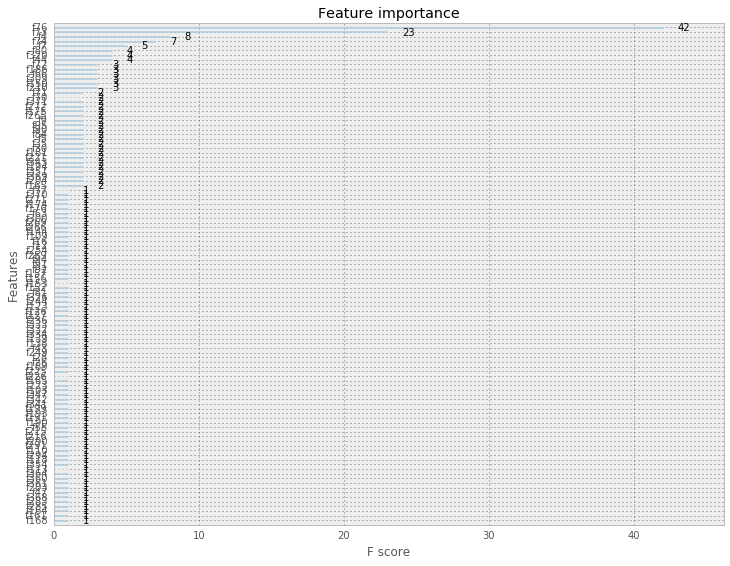

In [40]:
xgb.plot_importance(bst)

In [57]:
# df_prediction

In [59]:
# bst.save_model('in_relation.model')

In [68]:
pks = pickle.dump(bst, file=open('in_relation_xgb.model', 'a'))

In [66]:
# print pks

In [70]:
# load model and data in
bst_loaded = pickle.load(file=open('in_relation_xgb.model'))

In [71]:
bst_loaded.predict(d_test)

array([ 0.02759831,  0.05684074,  0.06788218, ...,  0.06788218,
        0.10331845,  0.11651848], dtype=float32)

In [72]:
'sex' in df

True

In [74]:
from sklearn.decomposition import PCA

In [136]:
def make_pca_fit(df):
    
    local_df = df.copy()
    local_df = local_df.astype(np.float64)
    del local_df['user_id']
    
    pca_model = PCA(n_components=5)
    pca_model.fit(local_df)
    return pca_model    

def difference(pca_fitted, vector_one, vector_two):
    
#     vector_one_o = vector_one.copy()
#     vector_two_o = vector_two.copy()
#     if isinstance(vector_one, pd.DataFrame):
#         del vector_one_o['user_id']
#         del vector_two_o['user_id']
        
    print len(vector_one), len(vector_two)
    vector_one_pca = pca_fitted.transform(vector_one)
    print vector_one_pca.shape
    vector_two_pca = pca_fitted.transform(vector_two)
    print vector_one_pca, vector_two_pca
    
    return np.linalg.norm(vector_one_pca - vector_two_pca)

In [137]:
pca_fitted = make_pca_fit(df)

In [133]:
# list(df[df['user_id'] == '28716273'].astype(float).as_matrix()[0])[1:]

In [138]:
%%time
difference(
    pca_fitted,
    list(df[df['user_id'] == '2190273'].astype(float).as_matrix()[0])[1:], 
    list(df[df['user_id'] == '28716273'].astype(float).as_matrix()[0])[1:]
)

378 378
(1, 5)
[[ -1.40936771e+08  -2.32363742e+04  -8.00793507e+04  -8.64965742e-01
   -4.21056453e-01]] [[  1.19357689e+08  -2.00695743e+04   9.50458481e+05  -1.18062120e+00
   -7.05748650e-01]]
CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 19 ms


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


260296500.28680065